# **Minimize KL-divergence between two distributions**


In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

try:
    import distrax
except:
    %pip install -qq distrax
    import distrax
try:
    import jaxopt
except:
    %pip install -qq jaxopt
    import jaxopt
try:
    import optax
except:
    %pip install -qq optax
    import optax
try:
    import seaborn as sns
except:
    %pip install -qq sample_data
    import seaborn
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled
latexify(width_scale_factor=1.2, fig_height=1.5, font_size=9)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [3]:
# generating a bimodal distribution q
mix = 0.5
mean_one, mean_two = 0.1, 3.7
scale_one, scale_two = 0.7, 0.9
q = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[mean_one, mean_two], scale=[scale_one, scale_two]),
)

In [4]:
key = jax.random.PRNGKey(1234)


def kl_sampling(theta, q, samples=100000):  # loss function when KL(p:q)
    p = distrax.Normal(loc=theta[0], scale=theta[1])
    sample_set = distrax.Normal(loc=0, scale=1).sample(seed=key, sample_shape=samples)
    sample_set = theta[0] + theta[1] * sample_set
    return jnp.mean(p.log_prob(sample_set) - q.log_prob(sample_set))


def kl_sampling_inverse(theta, q, samples=100000):  # loss function when KL(q:p)
    p = distrax.Normal(loc=theta[0], scale=theta[1])
    sample_set = q.sample(seed=key, sample_shape=samples)
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [5]:
def fit(params, optimizer, loss_fun, n_itr):
    opt_state = optimizer.init(params)
    for i in range(n_itr):
        samples = 1000
        loss_value, grads = jax.value_and_grad(kl_sampling)(params, q, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    return params

In [6]:
optimizer = optax.adam(learning_rate=1e-1)
n_itr = 150
params_one = jnp.array([10.0, 11.0])
params_one = fit(params=params_one, optimizer=optimizer, loss_fun=kl_sampling, n_itr=n_itr)
params_two = jnp.array([10.0, 11.0])
params_two = fit(params=params_one, optimizer=optimizer, loss_fun=kl_sampling_inverse, n_itr=n_itr)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


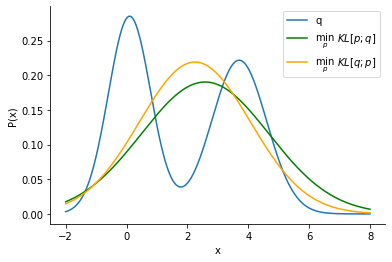

In [11]:
x = jnp.linspace(-2, 8, int(1e4))
plt.plot(x, q.prob(x), label="q")
plt.plot(
    x, distrax.Normal(loc=params_one[0], scale=params_one[1]).prob(x), color="green", label=r"$$\min_{p}\ KL[p ; q]$$"
)
plt.plot(
    x, distrax.Normal(loc=params_two[0], scale=params_two[1]).prob(x), color="orange", label=r"$$\min_p\ KL[q ; p]$$"
)
plt.legend()
plt.xlabel("x")
plt.ylabel("P(x)")
sns.despine()
savefig("minimize_kl_divergence")